In [34]:
%matplotlib inline
import bioread
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

In [35]:
class Segment(object):
    def __init__(self, name, start_index_text, start_index, seg_before):
        self.name = name
        self.start_index_text = start_index_text
        self.start_index = start_index
        self.end_index_text = ""
        self.end_index = 0
        self.before = seg_before
        self.after = None
        self.marker_inside_text = ""
        self.marker_inside_index = 0

    def make_df(self, file):
        data = {}
        for channel in file.named_channels:
            signal = np.array(file.named_channels[channel].data[self.start_index:self.end_index])
            data[channel] = signal
        self.df = pd.DataFrame(data)
        print('Dataframe of {0}:'.format(self.name))
        #print(self.df)


In [36]:
class Filedata(object):
    def __init__(self, filename):
        self.filename = filename
        self.segments = {}

    def preparedata(self):
        name_seg_before = None
        name_seg_after = None
        file = bioread.read_file('../' + self.filename)
        for m in file.event_markers:
            if self.filename == 'RAW_data/PB13.acq':
                if m.text == 'end 2D NF ':
                   m.text = 'end 2D NF'
                if m.text == 'Segment 1':
                    name = m.text
                    current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                    self.segments[name] = current_seg
                    name_seg_before = name
            if self.filename == 'RAW_data/PB12.acq':
                if m.text == 'ABBA end':
                   m.text = 'end ABBA'
                if m.text == 'end VR NF':
                   m.text = 'end NF VR'
                if m.text == 'Segment 3':
                   m.text = 'end MIST'
                if m.text == 'Segment 1' or m.text == 'Segment 2':
                    name = m.text
                    current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                    self.segments[name] = current_seg
                    name_seg_before = name
            if self.filename == 'RAW_data/PB5.acq':
                if m.text == 'end NF VR':
                   m.text = 'end VR NF'
                if m.text == 'Segment 1' or m.text == 'Segment 2':
                    name = m.text
                    current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                    self.segments[name] = current_seg
                    name_seg_before = name
            if self.filename == 'RAW_data/PB17.acq':
                if m.text == 'end 2D NF' and m.sample_index == 4400451:
                   m.text = 'end NF-VR'
                if m.text == 'Segment 1':
                    name = m.text
                    current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                    self.segments[name] = current_seg
                    name_seg_before = name
            if   m.text.startswith("start "):
                name = m.text.removeprefix("start ")
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                if name_seg_before != None:
                    current_seg.before = name_seg_before
                    self.segments[name_seg_before].after = name
                name_seg_before = name
            elif m.text.startswith("end "):
                name = m.text.removeprefix("end ")
                current_seg = self.segments[name]
                current_seg.end_index_text = m.text
                current_seg.end_index = m.sample_index
                current_seg.make_df(file)
                name_seg_before = name
            else:
                if name_seg_before != None:
                    print("insider: " + m.text)
                    self.segments[name_seg_before].marker_inside_text = m.text
                    self.segments[name_seg_before].marker_inside_index = m.sample_index
            print(m.text)

        # Out of the event_markers loop
        if self.filename == 'RAW_data/PB17.acq':
            current_seg = self.segments['Segment 1']
            current_seg.end_index_text = self.segments['ABBA'].start_index_text
            current_seg.end_index = self.segments['ABBA'].start_index
            current_seg.make_df(file)
        if self.filename == 'RAW_data/PB5.acq':
            current_seg = self.segments['Segment 1']
            current_seg.end_index_text = self.segments['Segment 2'].start_index_text
            current_seg.end_index = self.segments['Segment 2'].start_index
            current_seg.make_df(file)
            current_seg = self.segments['Segment 2']
            current_seg.end_index_text = self.segments['MIST'].start_index_text
            current_seg.end_index = self.segments['MIST'].start_index
            current_seg.make_df(file)
        if self.filename == 'RAW_data/PB12.acq':
            current_seg = self.segments['Segment 1']
            current_seg.end_index_text = self.segments['Segment 2'].start_index_text
            current_seg.end_index = self.segments['Segment 2'].start_index
            current_seg.make_df(file)
            current_seg = self.segments['Segment 2']
            current_seg.end_index_text = self.segments['ABBA'].start_index_text
            current_seg.end_index = self.segments['ABBA'].start_index
            current_seg.make_df(file)
        if self.filename == 'RAW_data/PB13.acq':
            current_seg = self.segments['Segment 1']
            current_seg.end_index_text = self.segments['ABBA'].start_index_text
            current_seg.end_index = self.segments['ABBA'].start_index
            current_seg.make_df(file)

In [41]:
def ECG_report(df, name):
    print('Segment {0}:'.format(name))
    nk.signal_plot(df, subplots=True, sampling_rate=1000)
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("all_{0}.png".format(name))
    plt.show()
    plt.close()

    print('ECG of {0}:'.format(name))
    nk.signal_plot(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    plt.title('ECG of {0}:'.format(name))
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("ecg_{0}.png".format(name))
    plt.xlim(0, 10)
    plt.ylim(-0.5,0.5)
    plt.show()
    plt.close()
    # Find peaks
    peaks, info = nk.ecg_peaks(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Compute HRV indices
    hrv = nk.hrv_time(peaks, sampling_rate=1000, show=True)
    plt.title('ECG Peaks of {0}:'.format(name))
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("hrv_{0}.png".format(name))
    plt.show()
    plt.close()
    print('HRV of segment {0}:'.format(name))
    print(hrv)
    #for col in hrv:
    #    print(col)
    print(hrv['HRV_MeanNN'])
    #print(hrv.iloc[0]['HRV_MeanNN'])
    print(hrv['HRV_SDNN'])
    #print(hrv.iloc[0]['HRV_SDNN'])
    print(hrv['HRV_RMSSD'])
    #print(hrv.iloc[0]['HRV_RMSSD'])

In [42]:
def EDA_report(df, name):
    #reportname = 'EDAreport_{0}.html'.format(name)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report=reportname)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report="text")
    signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000)
    nk.eda_plot(signals, info)
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("eda_{0}.png".format(name))
    plt.show()
    plt.close()
    print('EDA of segment {0}:'.format(name))
    #print(signals)
    #print(info)
    analyze_df = nk.eda_analyze(signals, sampling_rate=1000)
    print(analyze_df)



In [43]:
def main():
    fdatas = {}
    for filename in ['RAW_data/PB5.acq', 'RAW_data/PB12.acq', 'RAW_data/PB13.acq', 'RAW_data/PB17.acq']:
        fdata = Filedata(filename)
        fdata.preparedata()
        fdatas[filename] = fdata

    for fnam, fdat in fdatas.items():
        print('\nFile {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            ECG_report(seg.df, name)
            EDA_report(seg.df, name)
            #pass

        print('\nFor file {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            if seg.marker_inside_index != 0:
                print(seg.marker_inside_index)
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}] marker_inside label[{5}] marker_inside index [{6}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index, seg.marker_inside_text, seg.marker_inside_index))
            else:
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index))
        #first = ""
        #for name, seg in segments.items():
        #    if seg.before == None:
        #        first = name
        #        break
        #seg = segments[first]
        #while True:
        #    print(seg.name)
        #    if seg.after == None:
        #        break
        #    seg = segments[seg.after]
        #In Python 3.6+ dictionaries preserve insertion order.
        #sys.exit(0)
    return 0

insider: Segment 1
Segment 1
insider: Segment 2
Segment 2
start MIST
Dataframe of MIST:
end MIST
start 2D NF
insider: last block
last block
Dataframe of 2D NF:
end 2D NF
start ABBA
Dataframe of ABBA:
end ABBA
start VR NF
insider: last round
last round
Dataframe of VR NF:
end VR NF
Dataframe of Segment 1:
Dataframe of Segment 2:
insider: Segment 1
Segment 1
insider: Segment 2
Segment 2
start ABBA
Dataframe of ABBA:
end ABBA
start NF VR
insider: last block
last block
Dataframe of NF VR:
end NF VR
start MIST
Dataframe of MIST:
end MIST
Dataframe of Segment 1:
Dataframe of Segment 2:
insider: Segment 1
Segment 1
start ABBA
Dataframe of ABBA:
end ABBA
start 2D NF
Dataframe of 2D NF:
end 2D NF
start MIST
Dataframe of MIST:
end MIST
start VR NF
insider: last block
last block
Dataframe of VR NF:
end VR NF
Dataframe of Segment 1:
insider: Segment 1
Segment 1
start ABBA
Dataframe of ABBA:
end ABBA
insider: 

start 2D NF
insider: last block
last block
Dataframe of 2D NF:
end 2D NF
start MIST
Data

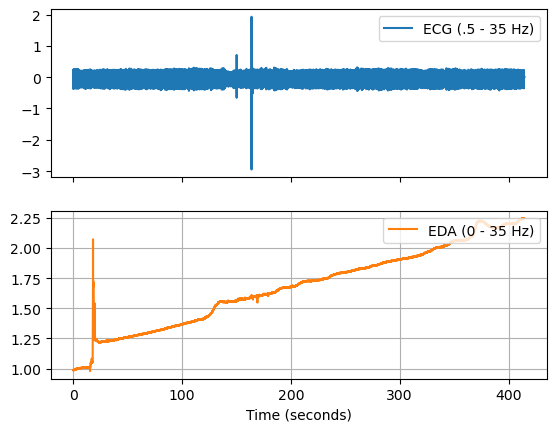

ECG of Segment 1:


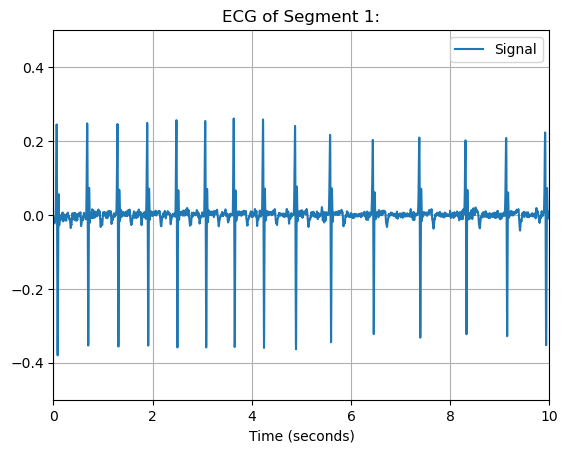

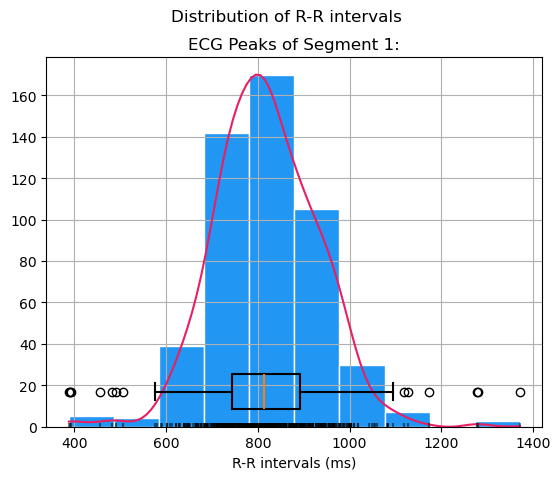

HRV of segment Segment 1:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  818.738614  118.888516   51.380648  105.173468   34.490727  115.097138   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  100.202256  100.300482  ...      149.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.186485        729.6        914.0  32.079208  65.544554      388.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1371.0  28.055556  398.4375  

[1 rows x 25 columns]
0    818.738614
Name: HRV_MeanNN, dtype: float64
0    118.888516
Name: HRV_SDNN, dtype: float64
0    100.202256
Name: HRV_RMSSD, dtype: float64


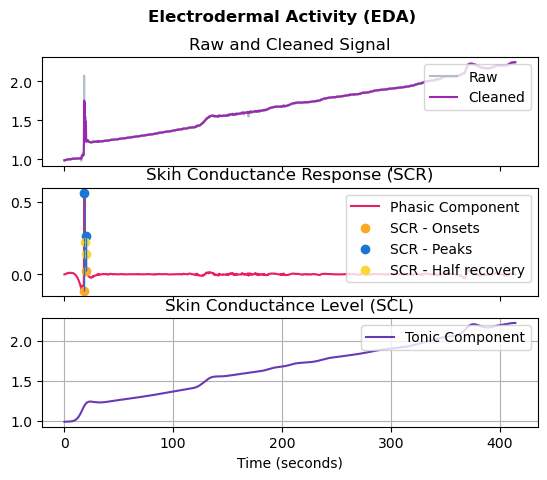

EDA of segment Segment 1:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          2.0                  0.465359      0.328578         0.000188   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001416             0.955875  
Segment Segment 2:


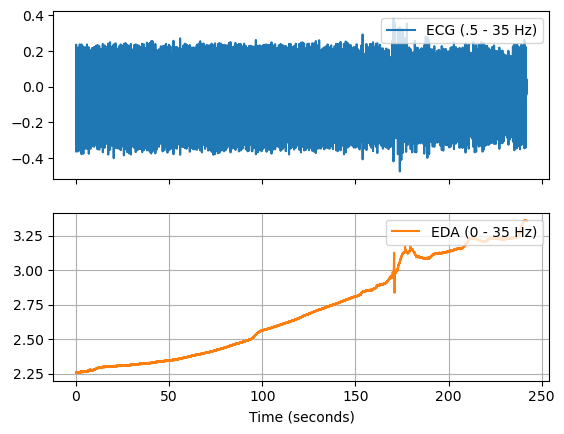

ECG of Segment 2:


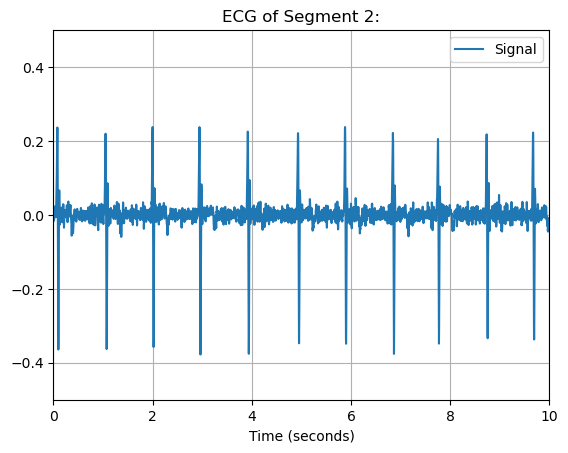

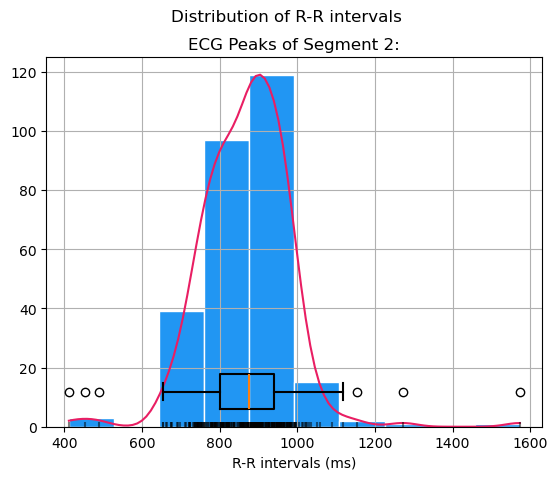

HRV of segment Segment 2:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  867.920578  112.193677   31.178223  106.970486         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  110.488048  110.686078  ...      140.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.015437        780.2        952.6  33.935018  70.036101      412.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1573.0  21.307692     500.0  

[1 rows x 25 columns]
0    867.920578
Name: HRV_MeanNN, dtype: float64
0    112.193677
Name: HRV_SDNN, dtype: float64
0    110.488048
Name: HRV_RMSSD, dtype: float64


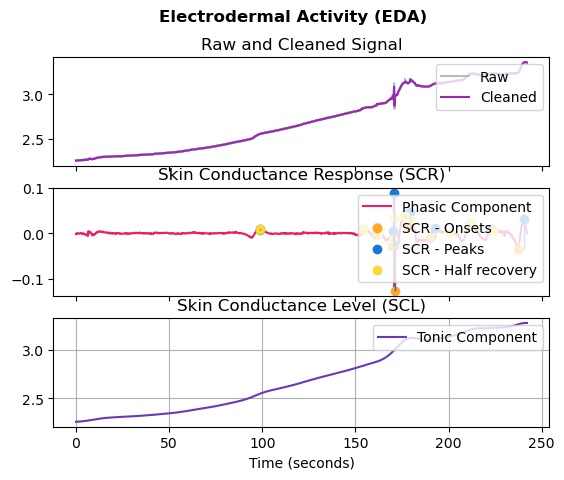

EDA of segment Segment 2:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         12.0                  0.033952      0.344005          0.00006   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000058             0.955245  
Segment MIST:


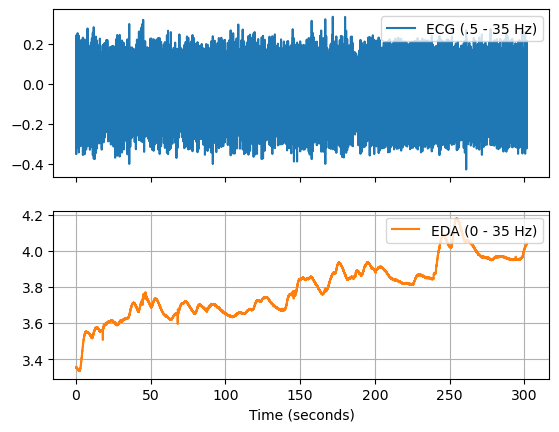

ECG of MIST:


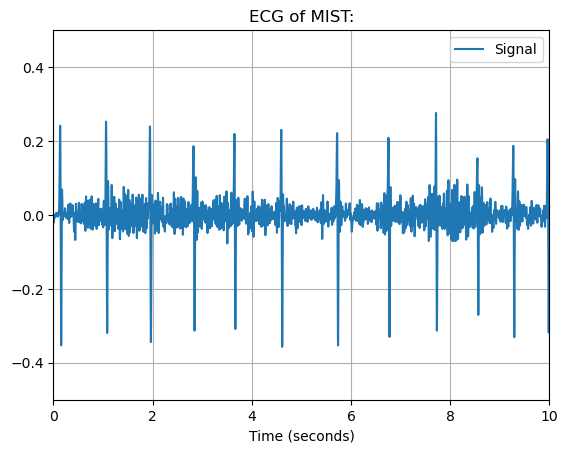

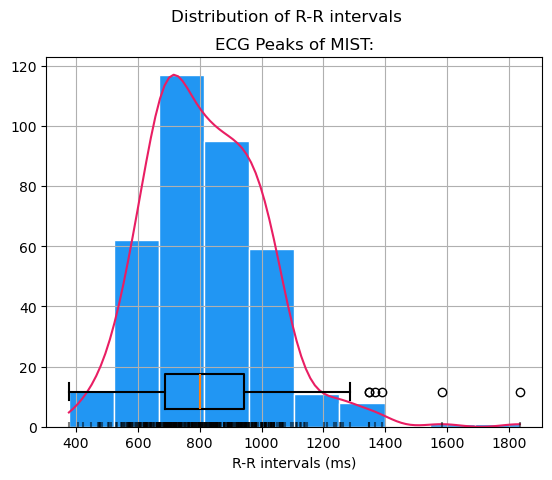

HRV of segment MIST:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0   821.23224  191.417919   49.730496  186.547678   19.347756  188.013341   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  220.362447  220.664567  ...     254.75   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0      0.86865        667.0        977.0  53.551913   77.04918      377.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1835.0     30.5  367.1875  

[1 rows x 25 columns]
0    821.23224
Name: HRV_MeanNN, dtype: float64
0    191.417919
Name: HRV_SDNN, dtype: float64
0    220.362447
Name: HRV_RMSSD, dtype: float64


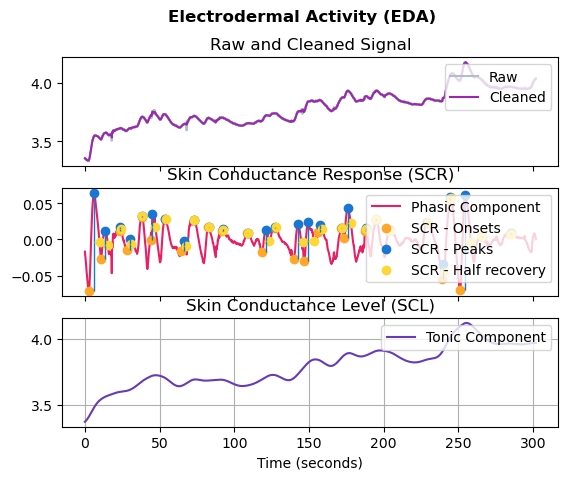

EDA of segment MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         28.0                  0.021613      0.151306         0.000456   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000235             0.887571  
Segment 2D NF:


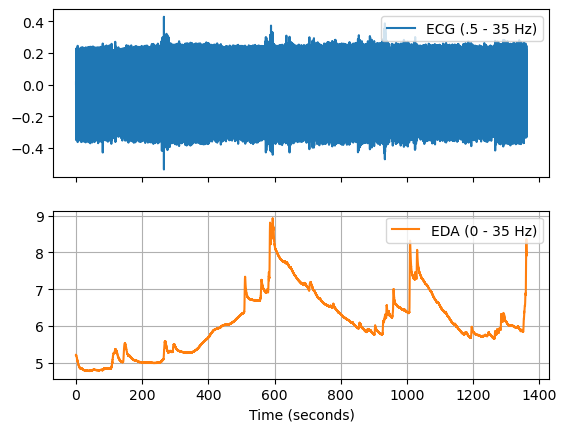

ECG of 2D NF:


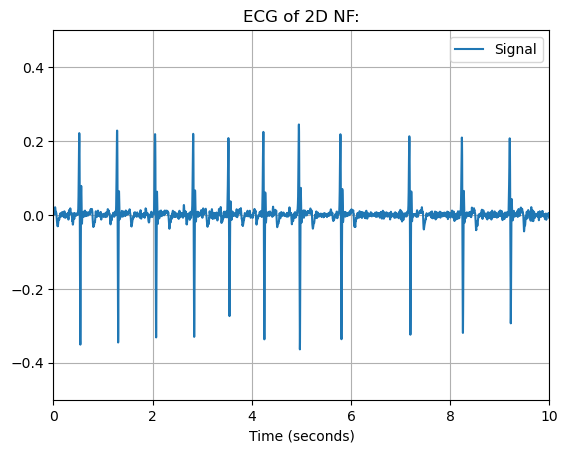

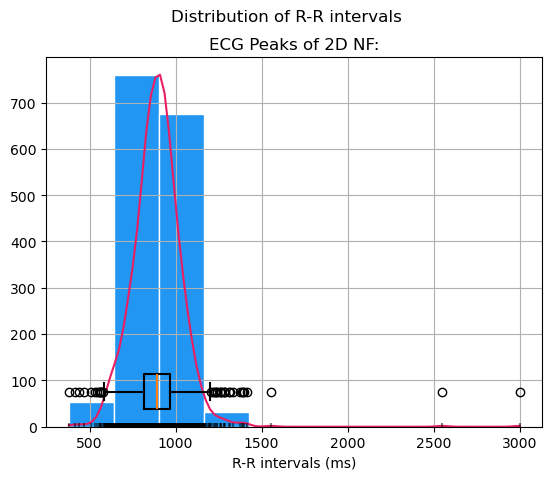

HRV of segment 2D NF:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  893.246719  149.125609   48.391291  128.274652   37.122165  138.451553   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   14.930819  141.704231  150.706622  150.756098  ...      155.5   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.989509        789.6        991.4   43.43832   71.91601      379.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     3001.0  28.222222       0.0  

[1 rows x 25 columns]
0    893.246719
Name: HRV_MeanNN, dtype: float64
0    149.125609
Name: HRV_SDNN, dtype: float64
0    150.706622
Name: HRV_RMSSD, dtype: float64


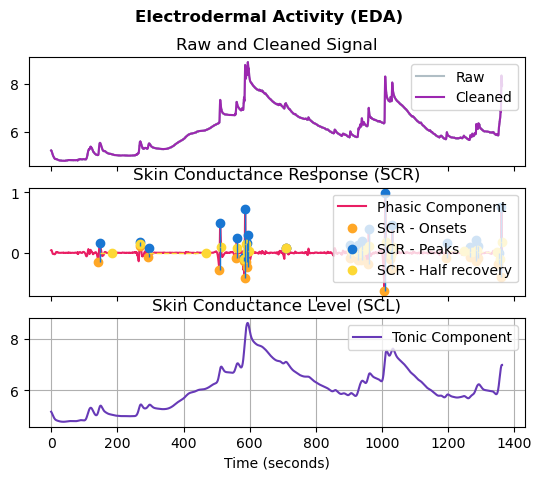

EDA of segment 2D NF:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         23.0                  0.427327      0.829799         0.004496   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.003957             0.971277  
Segment ABBA:


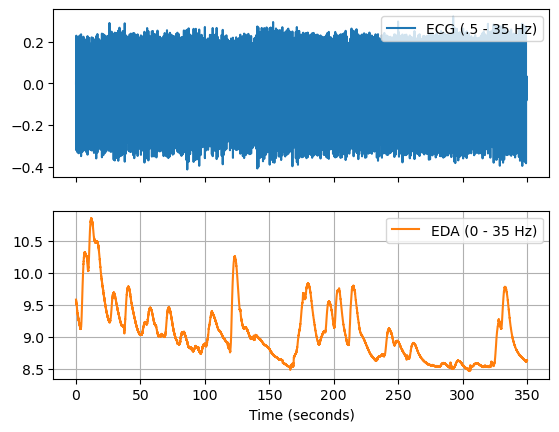

ECG of ABBA:


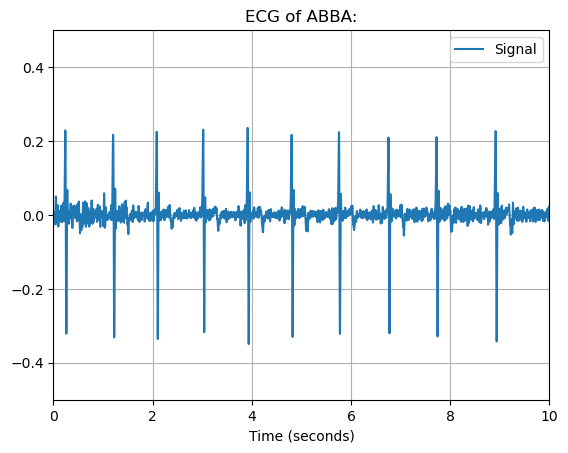

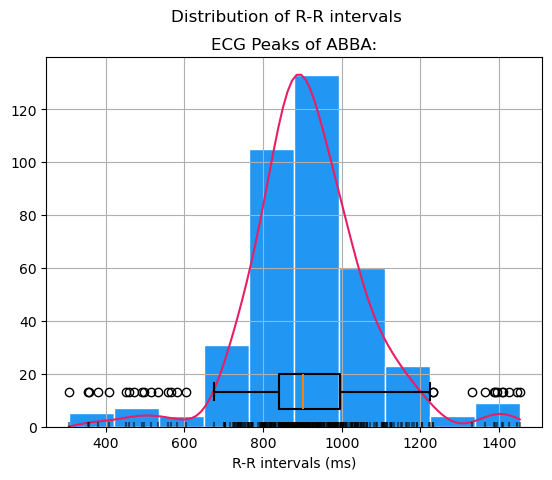

HRV of segment ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  913.349081  163.967203   37.845809  159.583494   27.544113  162.289596   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  161.320643  161.533172  ...      155.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.016406        818.0       1017.0  47.506562  75.065617      306.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1453.0  23.8125   609.375  

[1 rows x 25 columns]
0    913.349081
Name: HRV_MeanNN, dtype: float64
0    163.967203
Name: HRV_SDNN, dtype: float64
0    161.320643
Name: HRV_RMSSD, dtype: float64


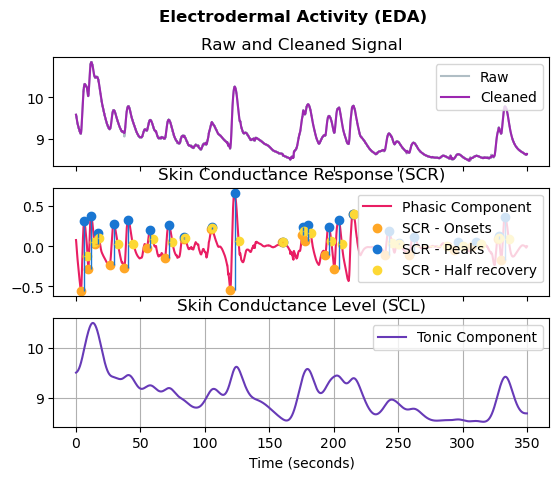

EDA of segment ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         23.0                  0.314092      0.411645         0.027951   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001759             0.735979  
Segment VR NF:


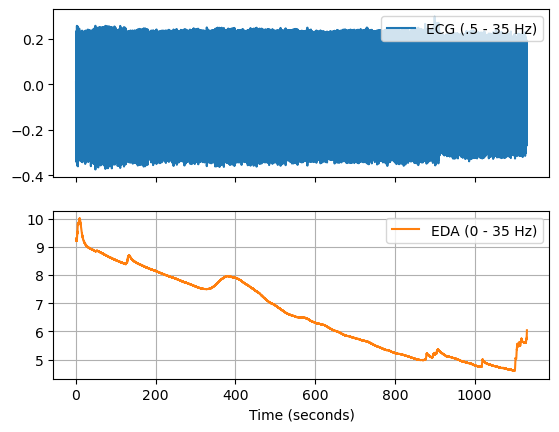

ECG of VR NF:


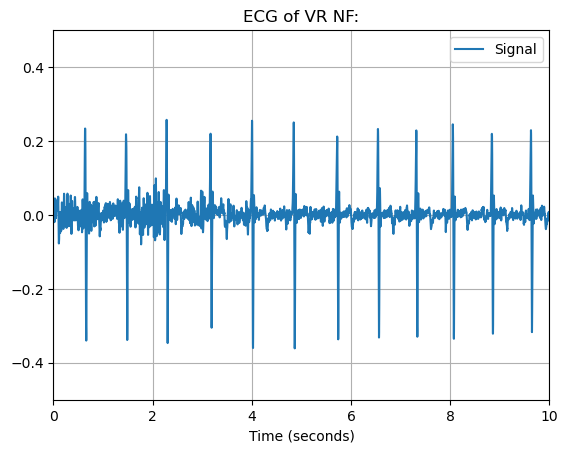

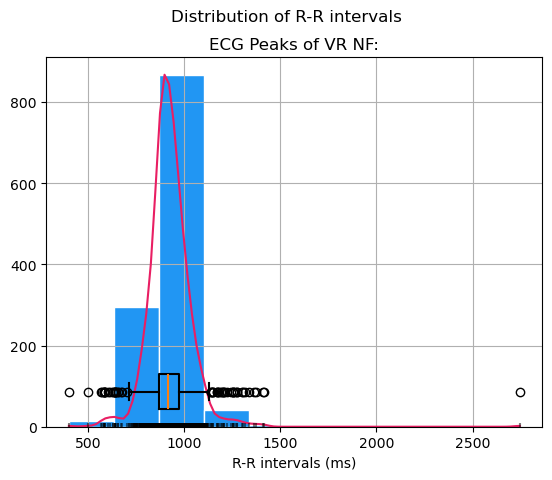

HRV of segment VR NF:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  924.569092  114.948497   37.873041   91.642274   24.867732   95.960952   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   33.669085  107.961776  109.608487  109.65336  ...      105.0     1.048719   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        858.4        992.0  33.442355  68.438267      400.0     2746.0   

    HRV_HTI  HRV_TINN  
0  20.04918       0.0  

[1 rows x 25 columns]
0    924.569092
Name: HRV_MeanNN, dtype: float64
0    114.948497
Name: HRV_SDNN, dtype: float64
0    109.608487
Name: HRV_RMSSD, dtype: float64


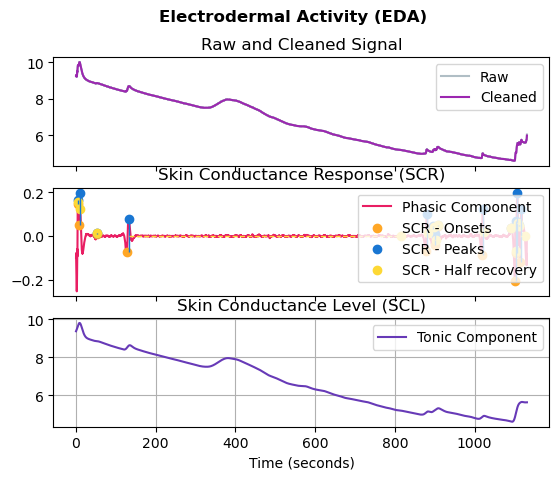

EDA of segment VR NF:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         14.0                  0.111888      1.415754         0.000253   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000074             0.991567  

For file RAW_data/PB5.acq:
segment: [Segment 1] before: [None] after [None] start [0] end [414405]
414405
segment: [Segment 2] before: [Segment 1] after [MIST] start [414405] end [656492] marker_inside label[Segment 2] marker_inside index [414405]
segment: [MIST] before: [Segment 2] after [2D NF] start [656492] end [958288]
2255175
segment: [2D NF] before: [MIST] after [ABBA] start [1312184] end [2674686] marker_inside label[last block] marker_inside index [2255175]
segment: [ABBA] before: [2D NF] after [VR NF] start [3757071] end [4106989]
5611674
segment: [VR NF] before: [ABBA] after [None] start [4710946] end [5842463] marker_inside label[last round] marker_inside index [5611674]

File RAW_data/PB12.acq:
Segment Segment 1:


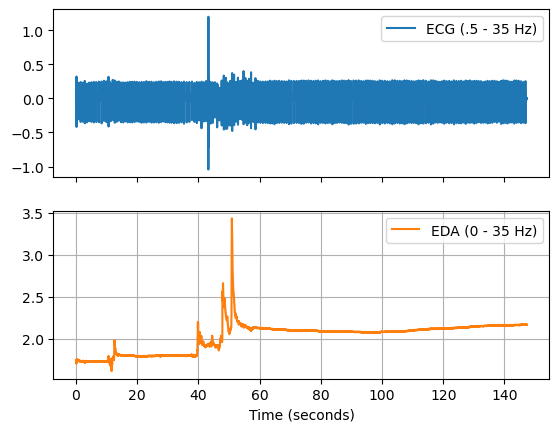

ECG of Segment 1:


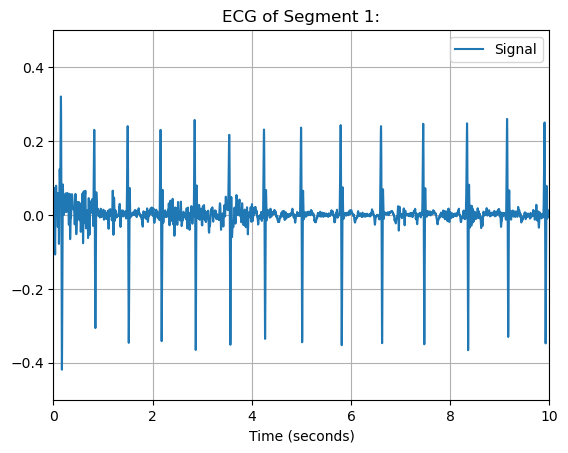

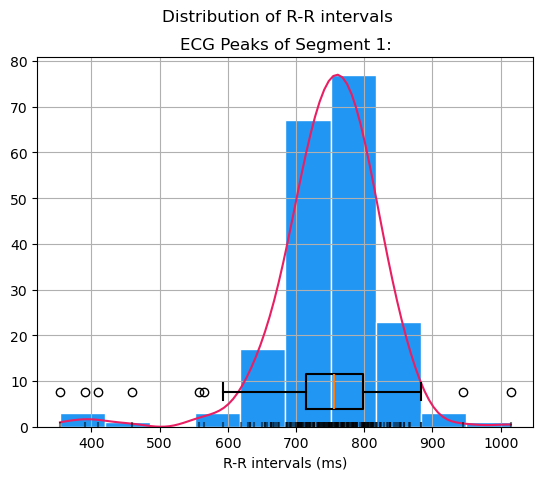

HRV of segment Segment 1:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  748.841026  80.703929         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN   92.85825  93.098308  ...       83.0     0.869109   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        704.8        804.4  14.871795  52.820513      354.0     1015.0   

   HRV_HTI  HRV_TINN  
0    16.25  429.6875  

[1 rows x 25 columns]
0    748.841026
Name: HRV_MeanNN, dtype: float64
0    80.703929
Name: HRV_SDNN, dtype: float64
0    92.85825
Name: HRV_RMSSD, dtype: float64


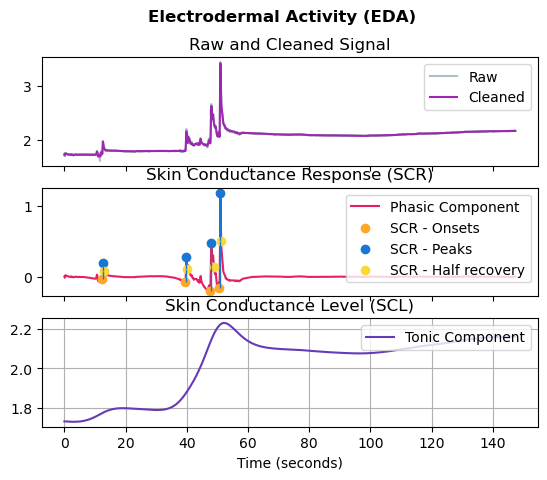

EDA of segment Segment 1:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          4.0                  0.652675      0.155252         0.001252   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001295             0.737371  
Segment Segment 2:


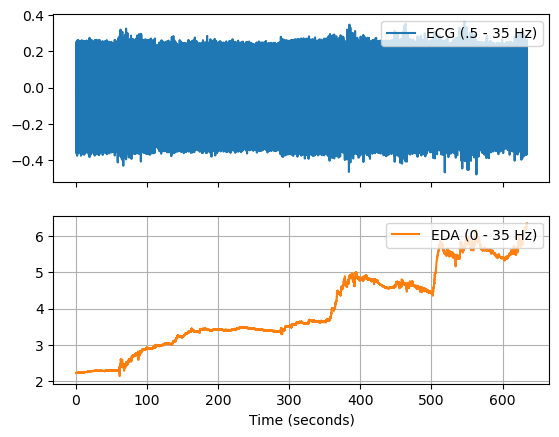

ECG of Segment 2:


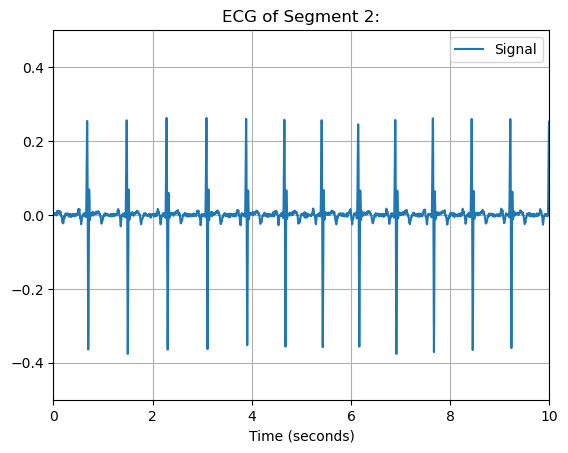

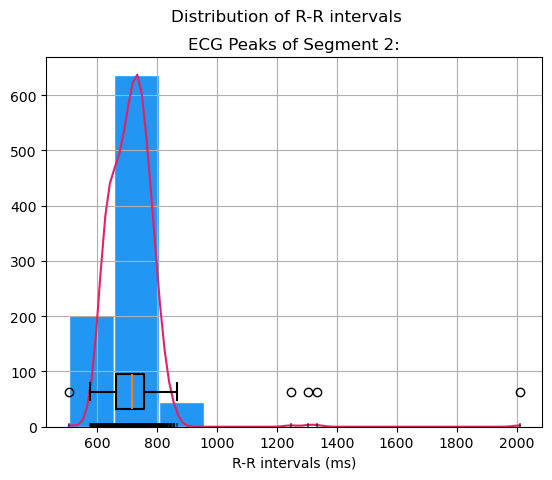

HRV of segment Segment 2:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  714.100338  81.678553   32.238208   65.683172   25.764674   71.154508   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN   87.74327  87.792684  ...       93.0     0.930881   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        652.0        765.0   6.426156  33.709132      506.0     2011.0   

     HRV_HTI  HRV_TINN  
0  16.425926   328.125  

[1 rows x 25 columns]
0    714.100338
Name: HRV_MeanNN, dtype: float64
0    81.678553
Name: HRV_SDNN, dtype: float64
0    87.74327
Name: HRV_RMSSD, dtype: float64


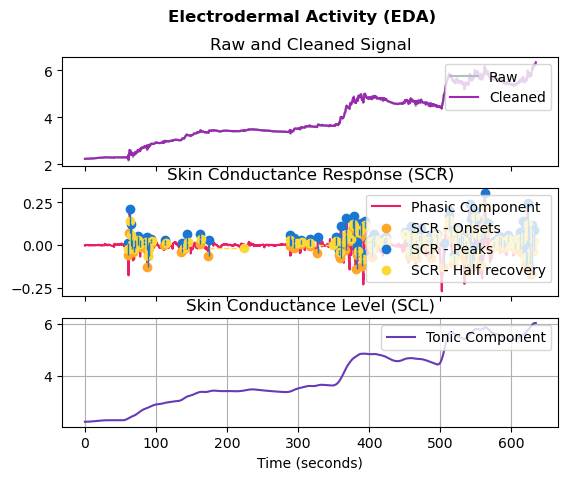

EDA of segment Segment 2:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0        100.0                  0.079123      1.098389         0.002594   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.003408              0.97387  
Segment ABBA:


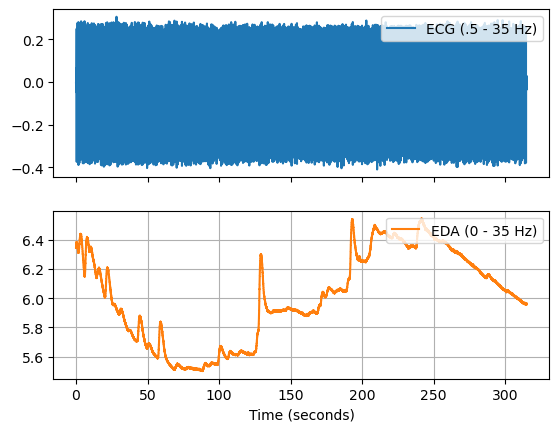

ECG of ABBA:


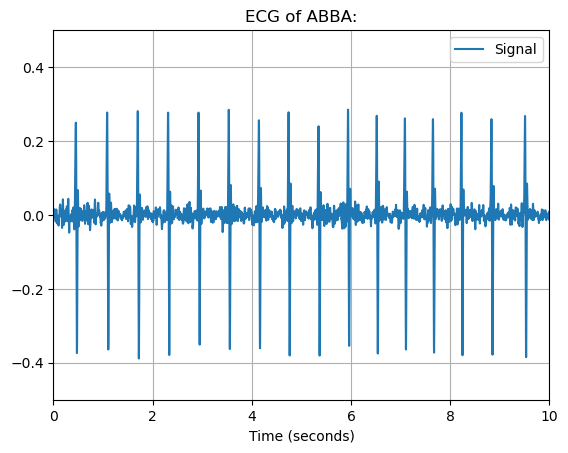

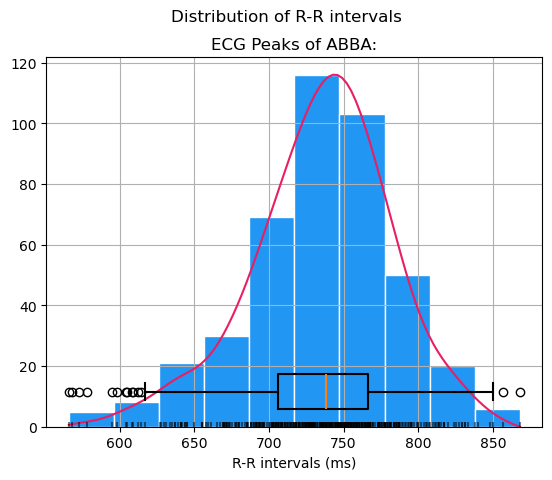

HRV of segment ABBA:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  733.834112  50.474962    21.05647   46.573417    3.780043   49.293495   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  30.652429  30.687159  ...       60.0     1.646687   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        697.0        773.6  10.046729  45.794393      566.0      868.0   

     HRV_HTI  HRV_TINN  
0  12.969697  257.8125  

[1 rows x 25 columns]
0    733.834112
Name: HRV_MeanNN, dtype: float64
0    50.474962
Name: HRV_SDNN, dtype: float64
0    30.652429
Name: HRV_RMSSD, dtype: float64


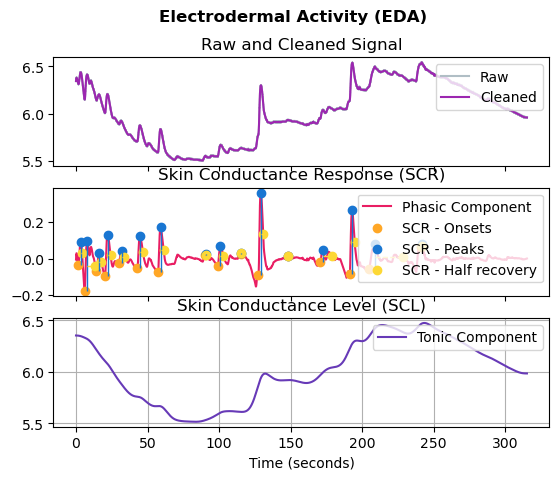

EDA of segment ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         16.0                   0.14818      0.302145         0.004213   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000689             0.935632  
Segment NF VR:


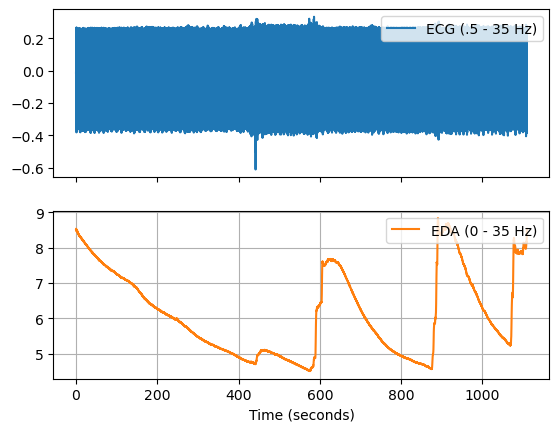

ECG of NF VR:


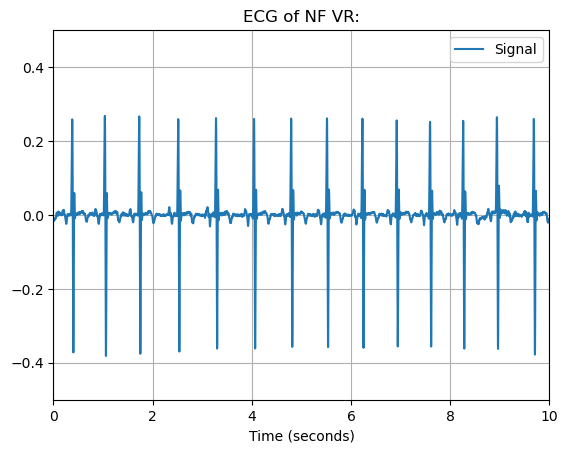

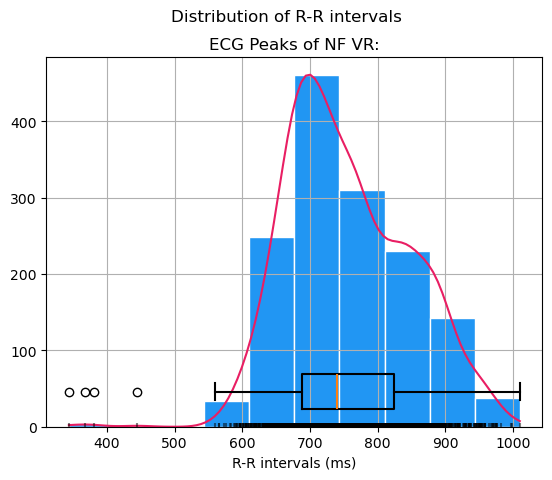

HRV of segment NF VR:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  755.441718  90.735669    33.11765   84.475492   29.347696   86.366496   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   23.651313   87.623251  44.072502  44.087476  ...      135.5     2.058782   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        678.0        841.8  20.381731  57.191547      344.0     1010.0   

     HRV_HTI  HRV_TINN  
0  21.895522       0.0  

[1 rows x 25 columns]
0    755.441718
Name: HRV_MeanNN, dtype: float64
0    90.735669
Name: HRV_SDNN, dtype: float64
0    44.072502
Name: HRV_RMSSD, dtype: float64


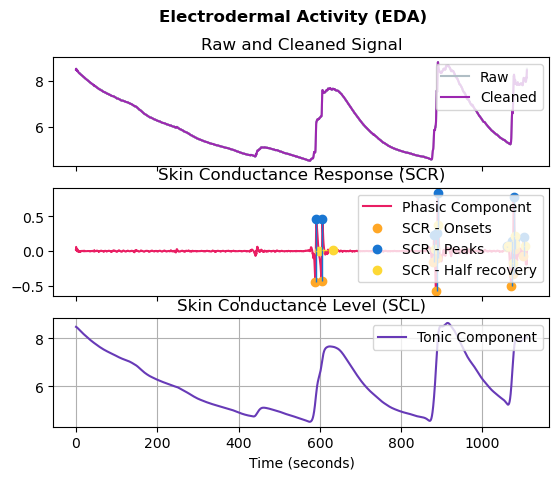

EDA of segment NF VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         10.0                  0.613372      1.189682         0.005066   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001291             0.972388  
Segment MIST:


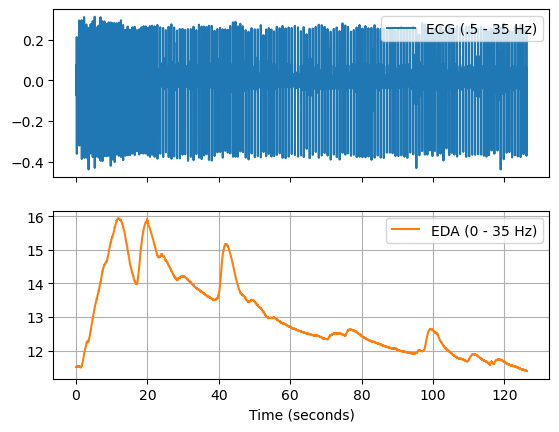

ECG of MIST:


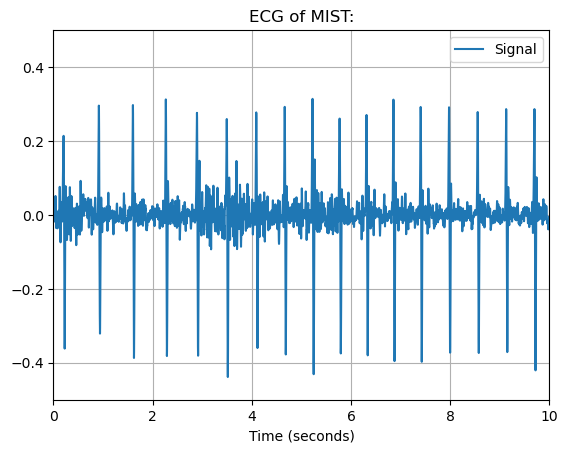

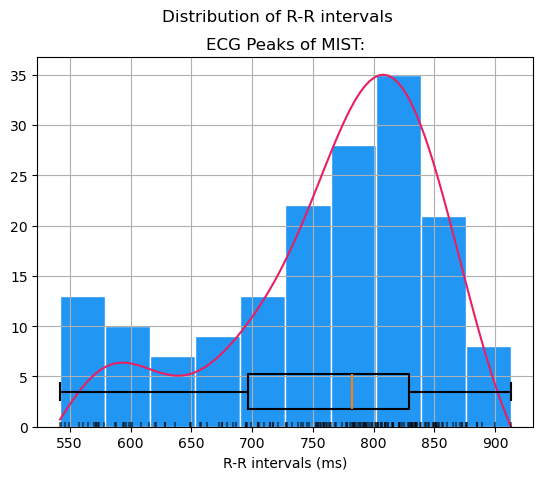

HRV of segment MIST:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0   754.36747  94.433385         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  34.252538  34.345342  ...      132.0     2.756975   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        673.0        835.0  12.048193   49.39759      542.0      913.0   

     HRV_HTI  HRV_TINN  
0  15.090909     312.5  

[1 rows x 25 columns]
0    754.36747
Name: HRV_MeanNN, dtype: float64
0    94.433385
Name: HRV_SDNN, dtype: float64
0    34.252538
Name: HRV_RMSSD, dtype: float64


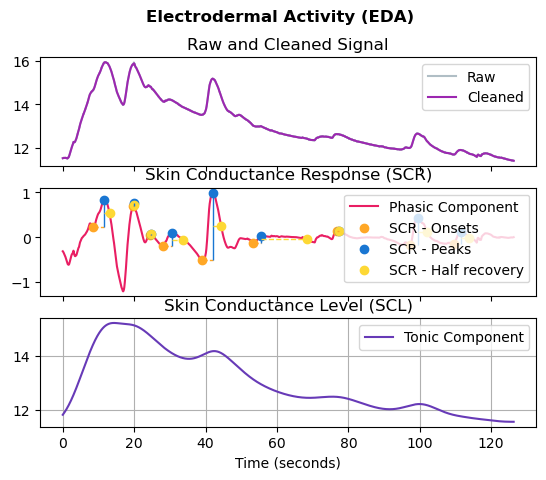

EDA of segment MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0          9.0                  0.392743      1.134298         0.070902   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000636             0.793185  

For file RAW_data/PB12.acq:
segment: [Segment 1] before: [None] after [None] start [0] end [147340]
147340
segment: [Segment 2] before: [Segment 1] after [ABBA] start [147340] end [781634] marker_inside label[Segment 2] marker_inside index [147340]
segment: [ABBA] before: [Segment 2] after [NF VR] start [781634] end [1096822]
2748482
segment: [NF VR] before: [ABBA] after [MIST] start [1848556] end [2957879] marker_inside label[last block] marker_inside index [2748482]
segment: [MIST] before: [NF VR] after [None] start [3788338] end [3914625]

File RAW_data/PB13.acq:
Segment Segment 1:


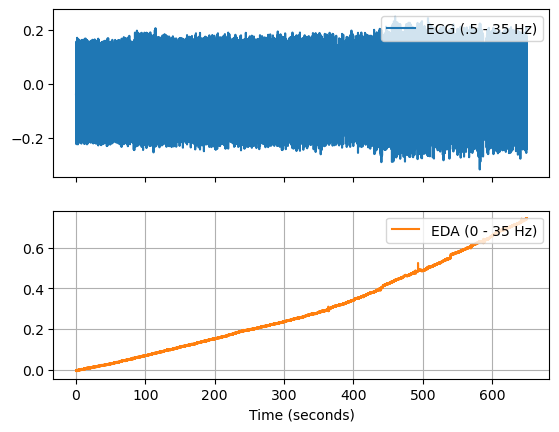

ECG of Segment 1:


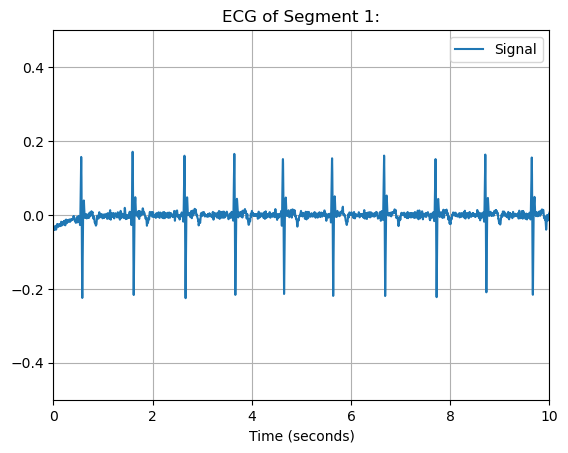

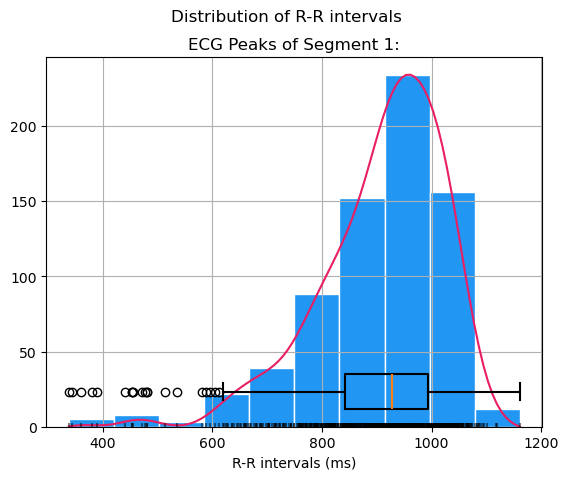

HRV of segment Segment 1:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  902.906815  125.958812    62.02624  106.472718    61.17101  114.535439   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  107.284701  107.358035  ...      150.5   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.174061        816.0       1004.4  39.916551  70.514604      338.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1161.0  23.193548  585.9375  

[1 rows x 25 columns]
0    902.906815
Name: HRV_MeanNN, dtype: float64
0    125.958812
Name: HRV_SDNN, dtype: float64
0    107.284701
Name: HRV_RMSSD, dtype: float64


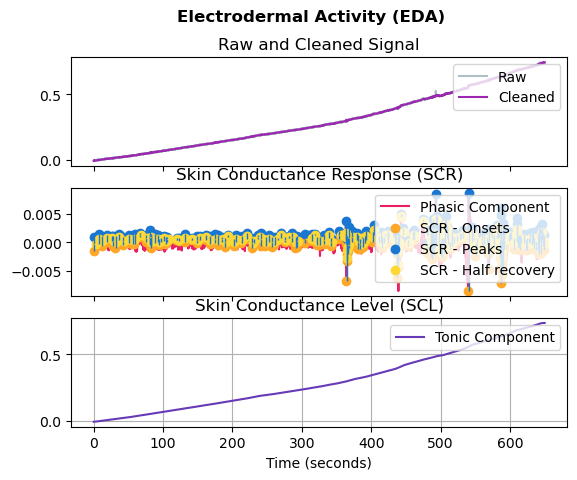

EDA of segment Segment 1:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0        187.0                  0.002144      0.213761         0.000001   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.015671             0.980503  
Segment ABBA:


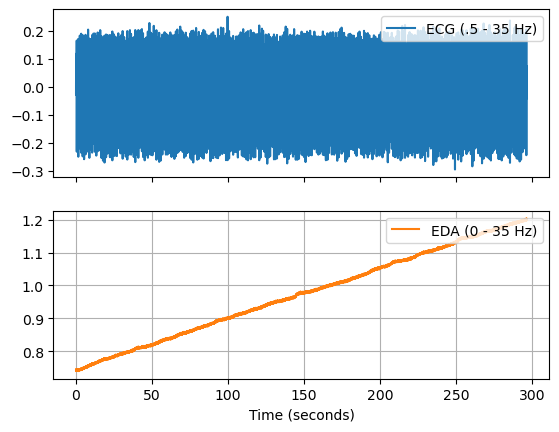

ECG of ABBA:


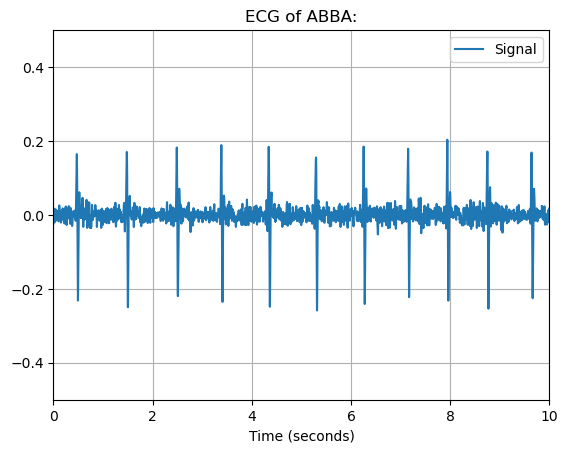

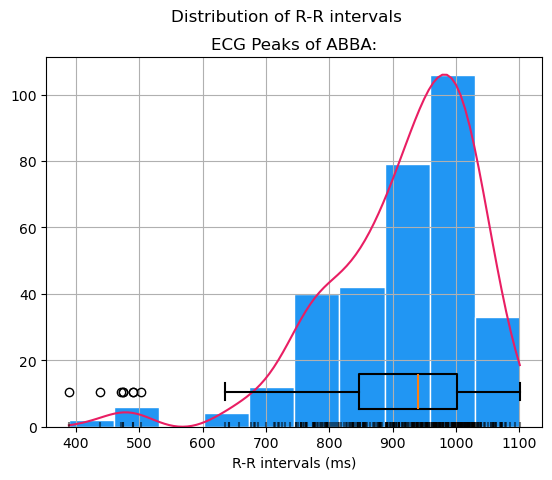

HRV of segment ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  911.978395  122.244753   21.739596  120.807798         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  118.469954  118.652262  ...     154.25   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.031863        821.4       1012.0   54.62963  80.555556      389.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1101.0    20.25    656.25  

[1 rows x 25 columns]
0    911.978395
Name: HRV_MeanNN, dtype: float64
0    122.244753
Name: HRV_SDNN, dtype: float64
0    118.469954
Name: HRV_RMSSD, dtype: float64


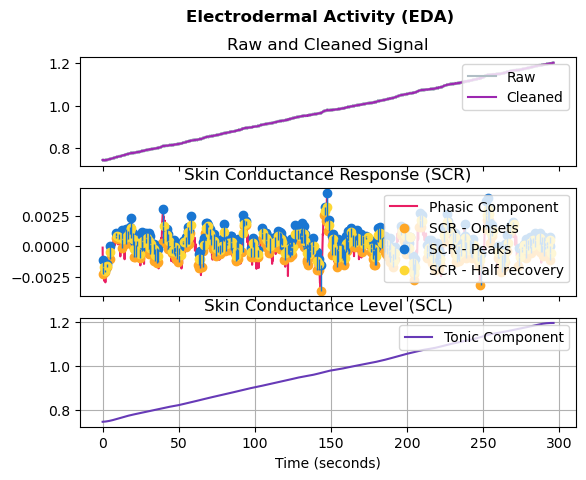

EDA of segment ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0        210.0                  0.001073      0.131982         0.000002   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000019             0.959028  
Segment 2D NF:


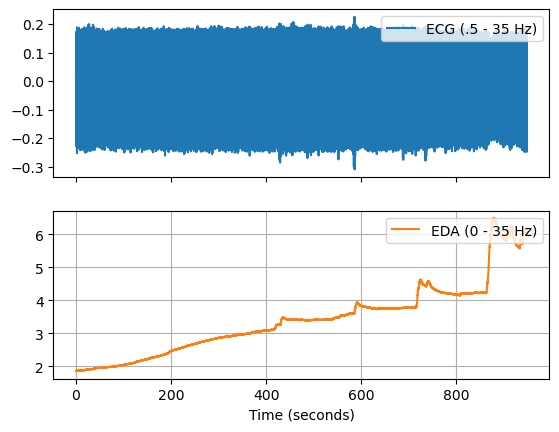

ECG of 2D NF:


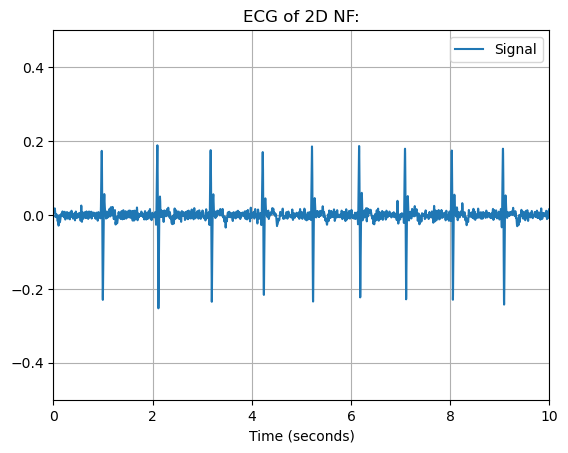

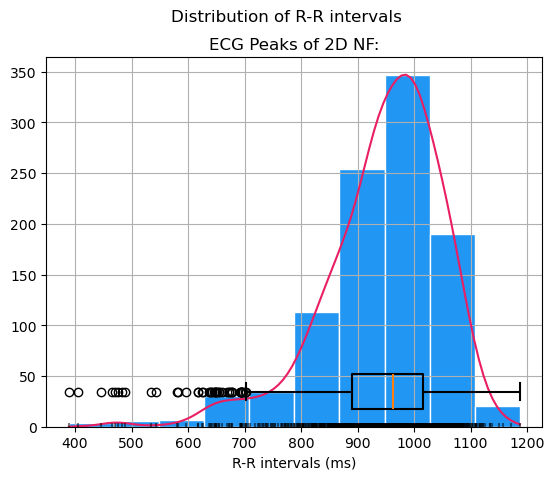

HRV of segment 2D NF:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  942.585075  111.550999   53.578207   91.923297   40.859598  102.037478   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   48.635555  104.308575  83.654466  83.69561  ...      125.0     1.333473   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        869.8       1031.0  33.731343  69.651741      389.0     1187.0   

     HRV_HTI  HRV_TINN  
0  21.382979       0.0  

[1 rows x 25 columns]
0    942.585075
Name: HRV_MeanNN, dtype: float64
0    111.550999
Name: HRV_SDNN, dtype: float64
0    83.654466
Name: HRV_RMSSD, dtype: float64


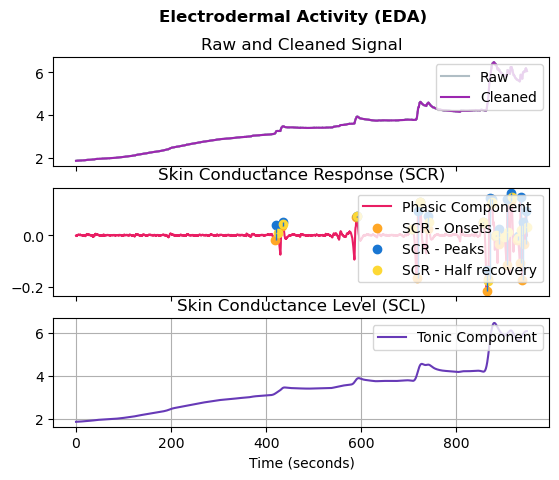

EDA of segment 2D NF:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         19.0                  0.093335      1.080408         0.001221   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.002133             0.977655  
Segment MIST:


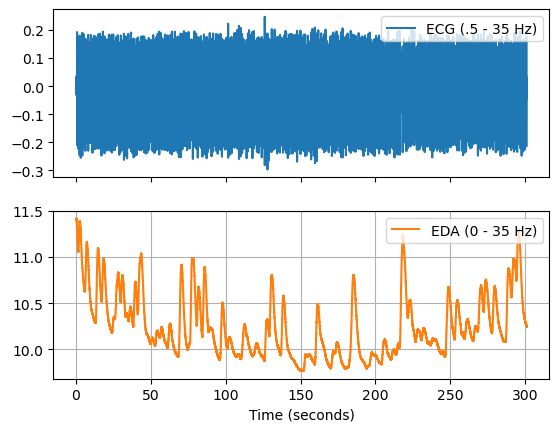

ECG of MIST:


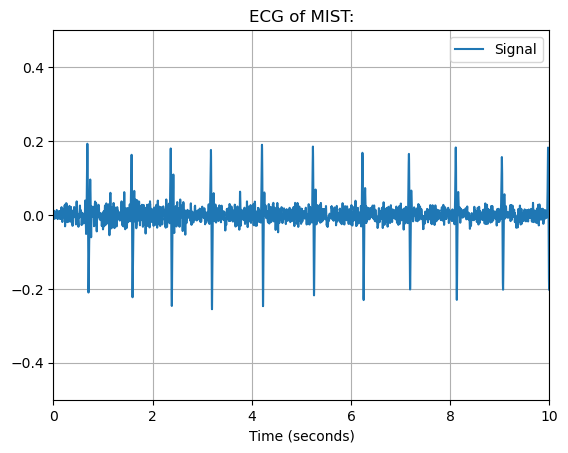

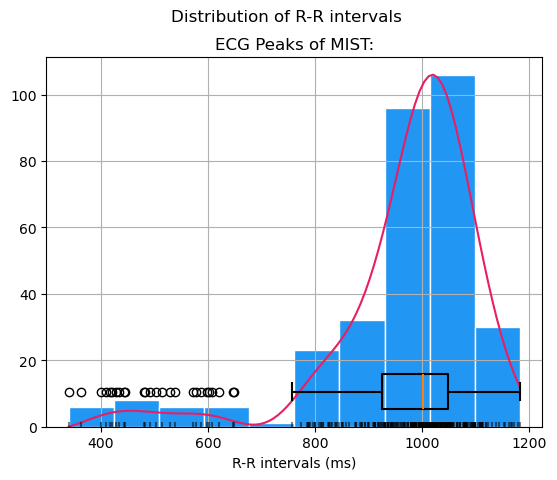

HRV of segment MIST:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  955.920382  161.351114   12.510957  159.740697    9.382971  158.435735   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  164.778232  165.041372  ...     122.75   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.979202        892.6       1055.0  51.910828  77.070064      340.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     1182.0  17.444444  726.5625  

[1 rows x 25 columns]
0    955.920382
Name: HRV_MeanNN, dtype: float64
0    161.351114
Name: HRV_SDNN, dtype: float64
0    164.778232
Name: HRV_RMSSD, dtype: float64


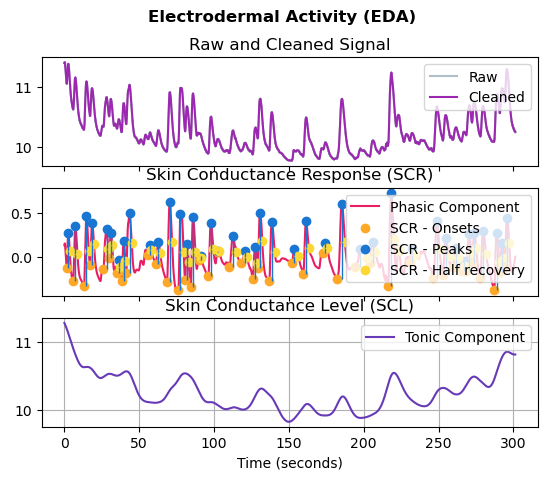

EDA of segment MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         42.0                  0.436158      0.273356         0.036362   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.002098             0.408855  
Segment VR NF:


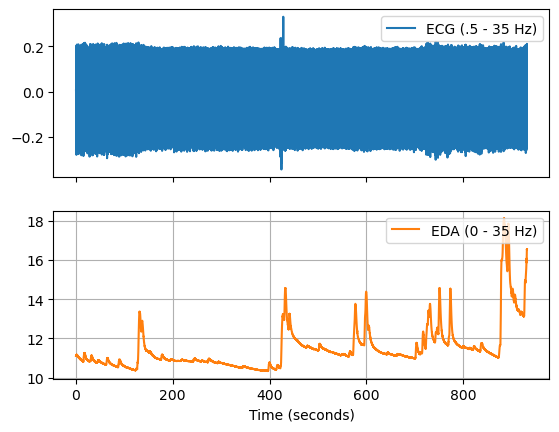

ECG of VR NF:


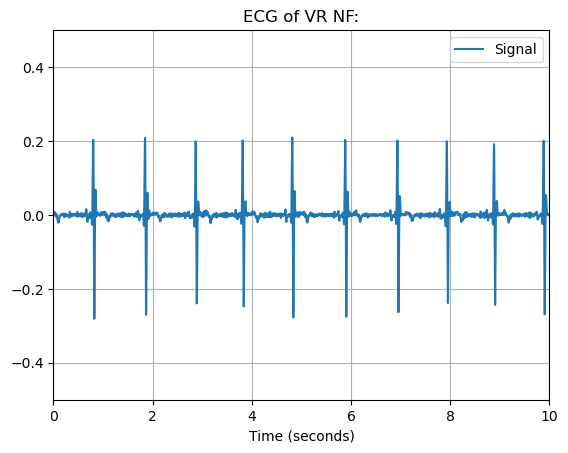

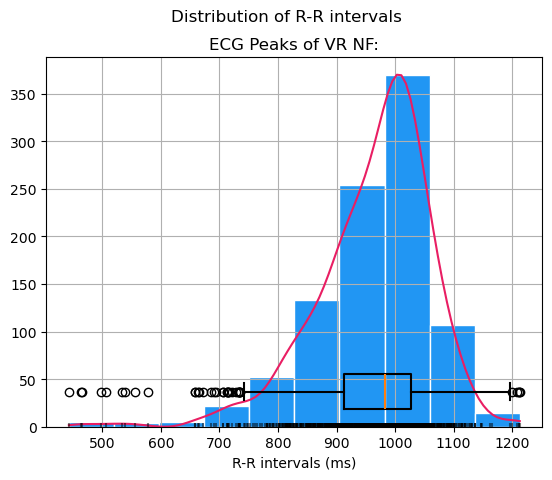

HRV of segment VR NF:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  963.074534  101.204122   44.348715    87.71992    33.28633    94.96342   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   28.331109   98.781523  83.541644  83.58443  ...      114.0     1.211421   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        894.0       1039.0   46.99793  76.604555      443.0     1213.0   

     HRV_HTI  HRV_TINN  
0  17.563636       0.0  

[1 rows x 25 columns]
0    963.074534
Name: HRV_MeanNN, dtype: float64
0    101.204122
Name: HRV_SDNN, dtype: float64
0    83.541644
Name: HRV_RMSSD, dtype: float64


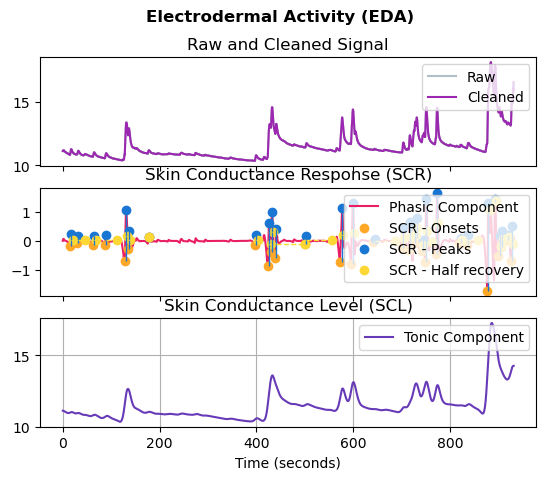

EDA of segment VR NF:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         32.0                  0.813025      1.096861         0.079839   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.006303             0.838469  

For file RAW_data/PB13.acq:
segment: [Segment 1] before: [None] after [ABBA] start [0] end [650059]
segment: [ABBA] before: [Segment 1] after [2D NF] start [650059] end [946410]
segment: [2D NF] before: [ABBA] after [MIST] start [1244777] end [2193167]
segment: [MIST] before: [2D NF] after [VR NF] start [2992623] end [3293888]
4535042
segment: [VR NF] before: [MIST] after [None] start [3634419] end [4566357] marker_inside label[last block] marker_inside index [4535042]

File RAW_data/PB17.acq:
Segment Segment 1:


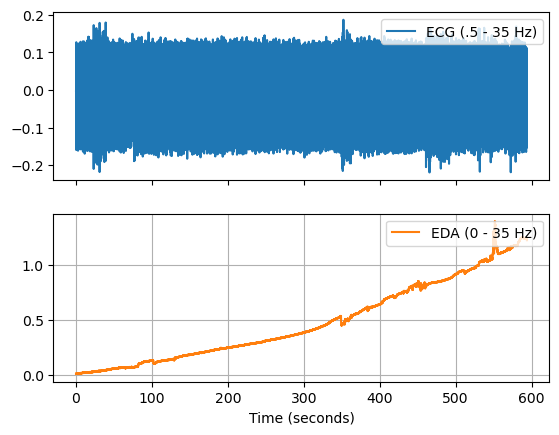

ECG of Segment 1:


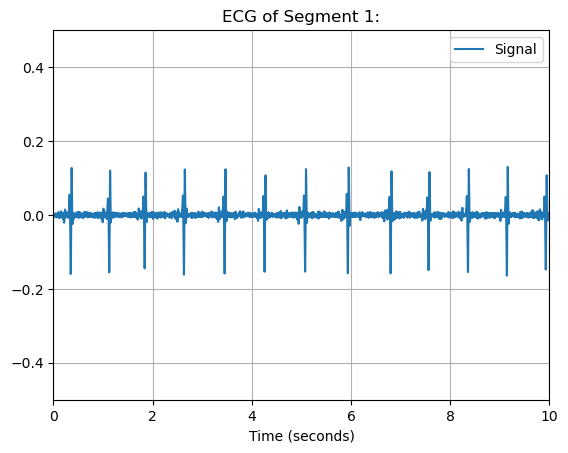

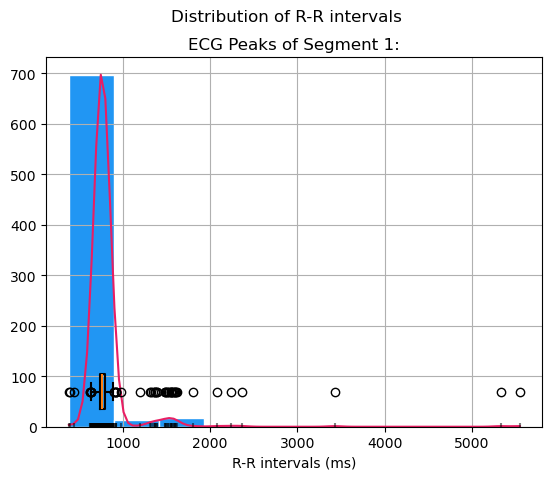

HRV of segment Segment 1:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0   809.31105  313.457815   38.318109  259.034077   34.829751  282.450307   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  434.85924  435.15658  ...       64.0     0.720826   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        727.0        806.6  21.282401  60.163711      383.0     5548.0   

     HRV_HTI  HRV_TINN  
0  14.096154       0.0  

[1 rows x 25 columns]
0    809.31105
Name: HRV_MeanNN, dtype: float64
0    313.457815
Name: HRV_SDNN, dtype: float64
0    434.85924
Name: HRV_RMSSD, dtype: float64


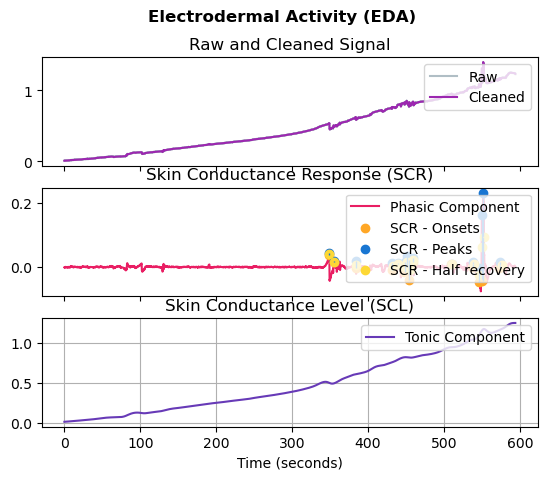

EDA of segment Segment 1:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         15.0                  0.049639      0.357712         0.000137   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.051195             0.976222  
Segment ABBA:


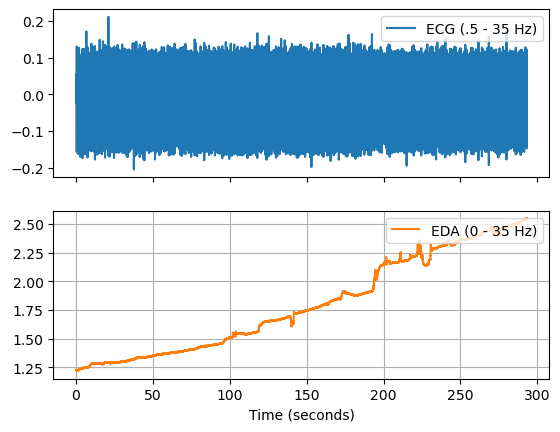

ECG of ABBA:


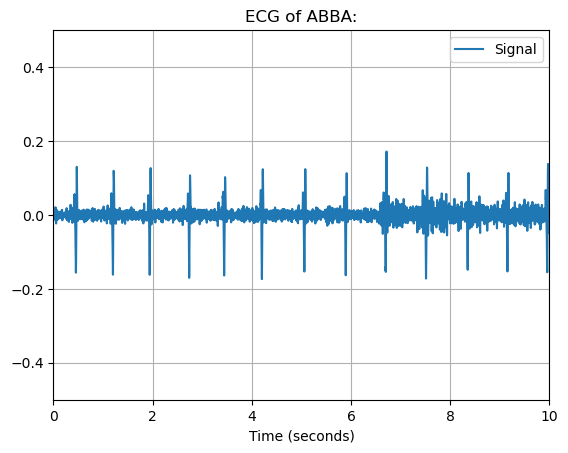

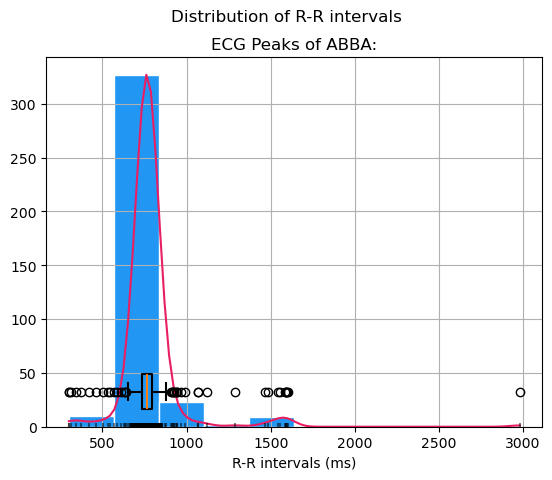

HRV of segment ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  786.567204  189.378735    35.42089  167.889085         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  255.809233  256.144535  ...       58.5   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.740312        730.0        804.0  29.301075  64.247312      301.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     2980.0   11.625  539.0625  

[1 rows x 25 columns]
0    786.567204
Name: HRV_MeanNN, dtype: float64
0    189.378735
Name: HRV_SDNN, dtype: float64
0    255.809233
Name: HRV_RMSSD, dtype: float64


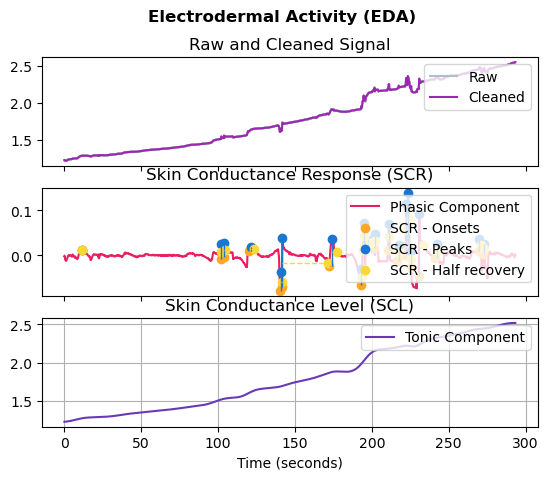

EDA of segment ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         20.0                  0.049995      0.415329         0.000361   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.001544             0.961734  
Segment 2D NF:


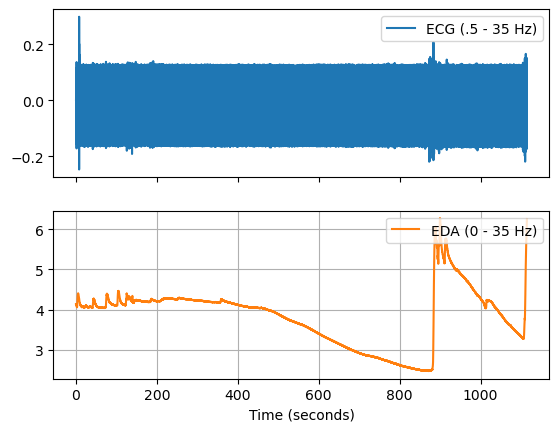

ECG of 2D NF:


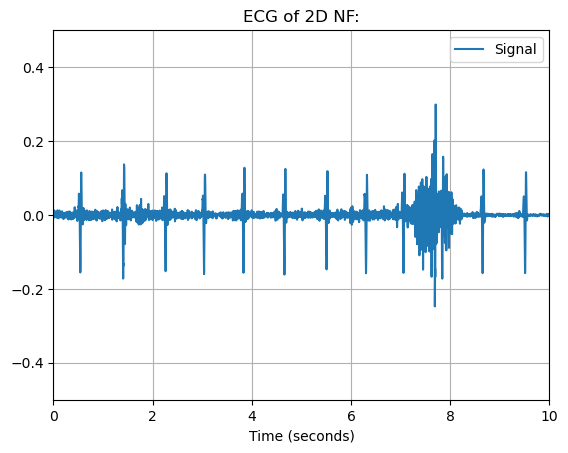

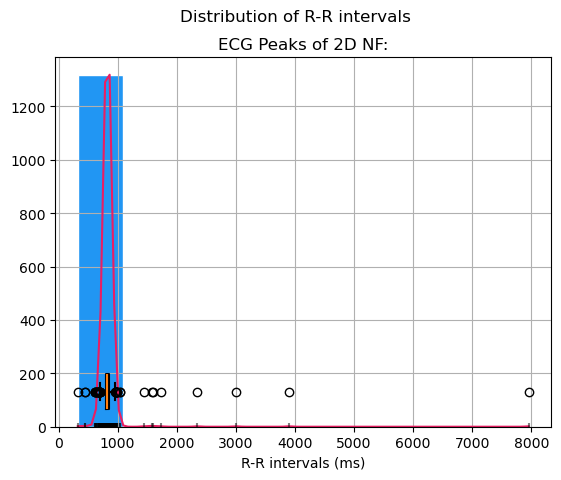

HRV of segment 2D NF:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  838.478523  235.818041   21.158378   122.83551   14.418152  145.311284   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0   16.984623   174.87008  318.769773  318.885935  ...       63.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.739775        789.0        868.0  24.943482   69.48003      325.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     7956.0  14.910112       0.0  

[1 rows x 25 columns]
0    838.478523
Name: HRV_MeanNN, dtype: float64
0    235.818041
Name: HRV_SDNN, dtype: float64
0    318.769773
Name: HRV_RMSSD, dtype: float64


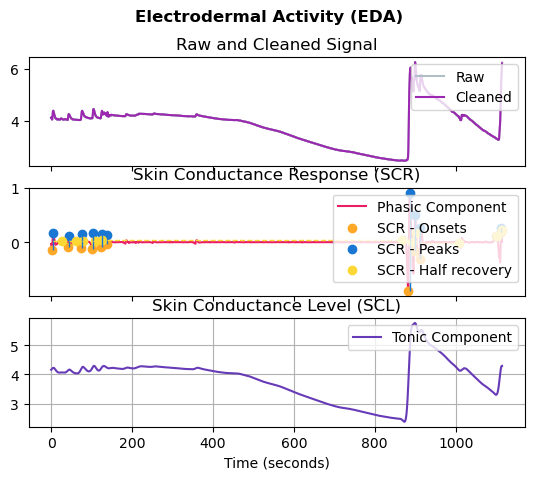

EDA of segment 2D NF:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         11.0                  0.415671       0.70504         0.006398   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.003603             0.943994  
Segment MIST:


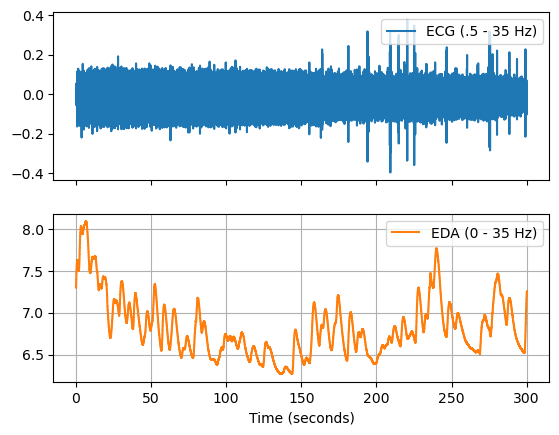

ECG of MIST:


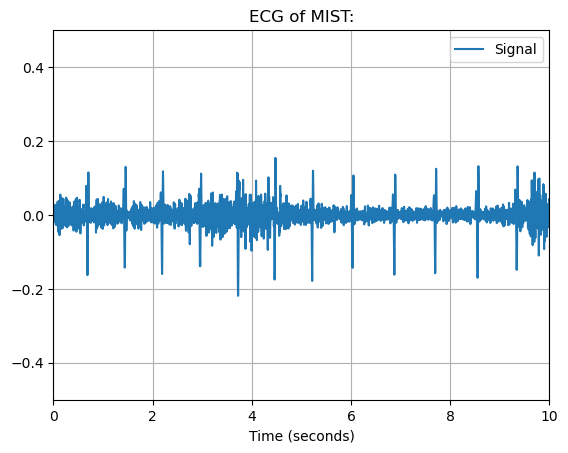

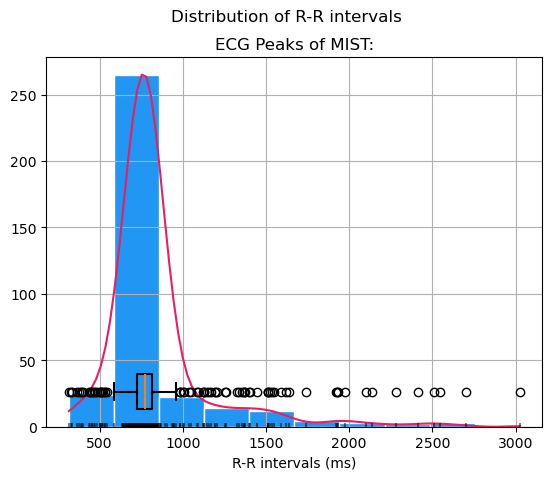

HRV of segment MIST:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  854.905714  347.782578   76.281753  342.466604         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  490.769693  491.474288  ...       94.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.708647        713.0        840.2  48.571429  74.285714      316.0   

   HRV_MaxNN    HRV_HTI  HRV_TINN  
0     3025.0  14.583333  476.5625  

[1 rows x 25 columns]
0    854.905714
Name: HRV_MeanNN, dtype: float64
0    347.782578
Name: HRV_SDNN, dtype: float64
0    490.769693
Name: HRV_RMSSD, dtype: float64


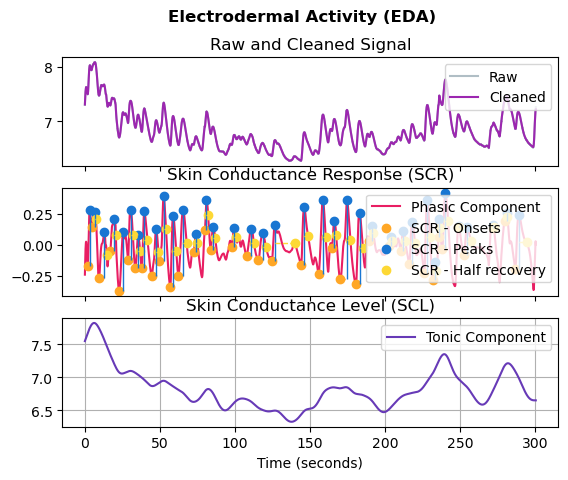

EDA of segment MIST:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         38.0                   0.31408      0.305532         0.020321   

   EDA_SympatheticN  EDA_Autocorrelation  
0           0.00224             0.619226  
Segment NF-VR:


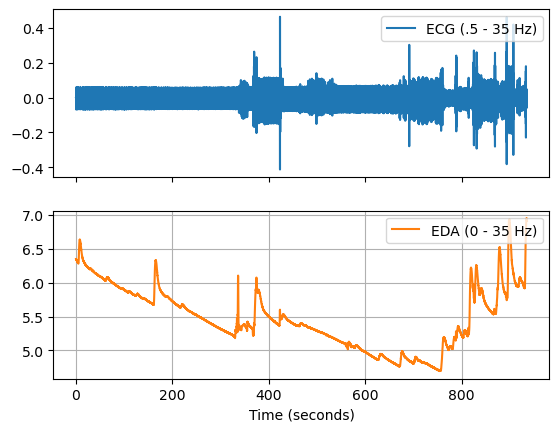

ECG of NF-VR:


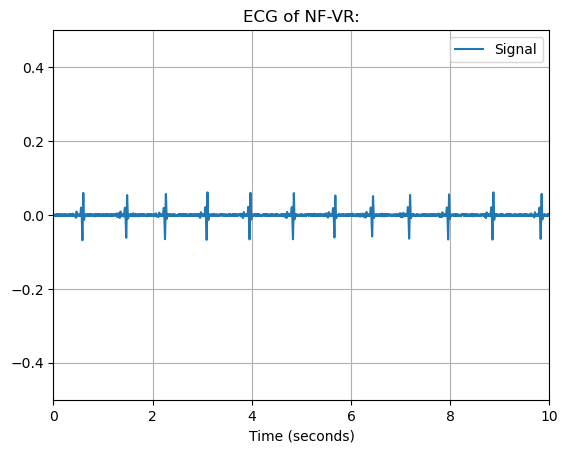

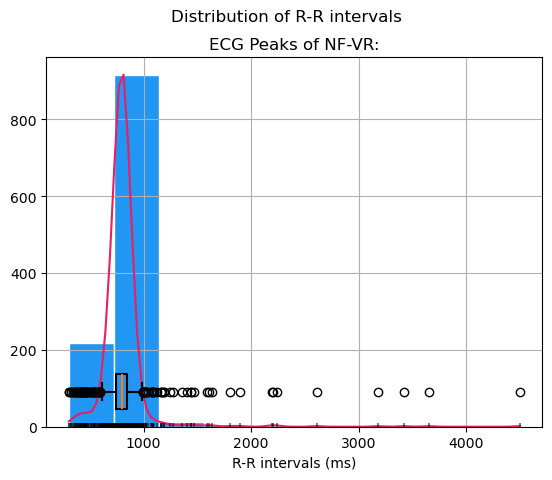

HRV of segment NF-VR:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  805.437069  233.994851  125.900754  175.390601   63.496339  177.317921   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   16.455072  158.578799  301.262059  301.39173  ...      96.25     0.776715   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        728.0        854.0  31.982759  70.258621      304.0     4501.0   

     HRV_HTI  HRV_TINN  
0  19.333333       0.0  

[1 rows x 25 columns]
0    805.437069
Name: HRV_MeanNN, dtype: float64
0    233.994851
Name: HRV_SDNN, dtype: float64
0    301.262059
Name: HRV_RMSSD, dtype: float64


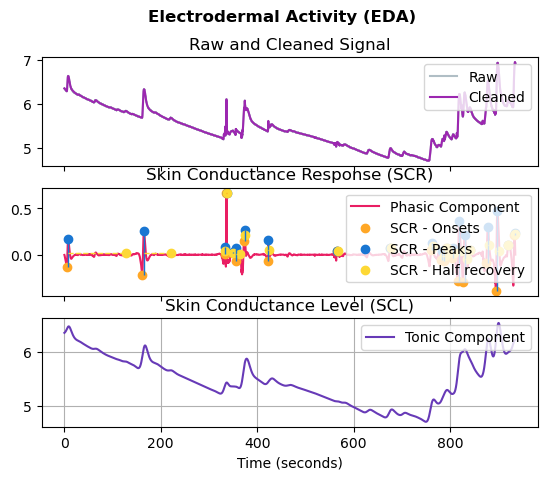

EDA of segment NF-VR:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         22.0                  0.190835      0.441266         0.005224   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.002336             0.922403  

For file RAW_data/PB17.acq:
segment: [Segment 1] before: [None] after [ABBA] start [0] end [593843]
1195628
segment: [ABBA] before: [Segment 1] after [2D NF] start [593843] end [887091] marker_inside label[] marker_inside index [1195628]
2131240
segment: [2D NF] before: [ABBA] after [MIST] start [1230799] end [2345386] marker_inside label[last block] marker_inside index [2131240]
segment: [MIST] before: [2D NF] after [NF-VR] start [2846539] end [3146741]
4365540
segment: [NF-VR] before: [MIST] after [None] start [3464924] end [4400451] marker_inside label[last block] marker_inside index [4365540]


0

In [44]:
main()